In [1]:
from jetstream_hugo.definitions import *
from jetstream_hugo.plots import *
from jetstream_hugo.data import *
from jetstream_hugo.anyspell import *
from jetstream_hugo.jet_finding import *
from jetstream_hugo.clustering import *
import intake

import colormaps

%load_ext autoreload
%autoreload 2
%matplotlib inline

# from dask.distributed import Client, progress
# client = Client(**COMPUTE_KWARGS)

# CESM jets

In [2]:
ds = xr.open_dataset("/storage/workspaces/giub_meteo_impacts/ci01/CESM2/flat_wind/ds.zarr", engine="zarr")
ds = ds.chunk({"member": 1, "time": 100, "lat": -1, "lon": -1})
dh = DataHandler(ds, "/storage/workspaces/giub_meteo_impacts/ci01/CESM2/flat_wind/results")
exp = JetFindingExperiment(dh)
client = Client(**COMPUTE_KWARGS)
exp.find_jets()
# dfs = []
# for f in exp.path.joinpath("jets").glob("*.pkl"):
#     dfs.append(load_pickle(f))
# df = pd.concat(dfs).sort_index(level=list(dfs[0].index.names))

Sending large graph of size 19.59 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.


points         lev  \
member       time                jet ID orig_points                       
r10i1181p1f1 1980-01-01 12:00:00 0      0                 4  168.225082   
                                        1                 5  168.225082   
                                        2                 6  168.225082   
                                        3                 7  168.225082   
                                        4                 8  168.225082   
...                                                     ...         ...   
r9i1301p1f1  2099-12-31 12:00:00 4      48              147  232.828613   
                                        49              148  232.828613   
                                        50              149  232.828613   
                                        51              150  232.828613   
                                        52              151  232.828613   

                                                             s          u  \
member       time                jet ID orig_points                         
r10i1181p1f1 1980-01-01 12:00:00 0      0            36.896562  35.083227   
                                        1            37.408511  35.046412   
                                        2            37.493301  34.321997   
                                        3            38.001743  33.940573   
                                        4            39.925290  35.142486   
...                                                        ...        ...   
r9i1301p1f1  2099-12-31 12:00:00 4      48           48.919605  47.183419   
                                        49           49.292256  48.201736   
                                        50           48.562919  47.119582   
                                        51           47.196370  46.410815   
                                        52           47.811852  47.346846   

                                                             v         sigma  \
member       time                jet ID orig_points                            
r10i1181p1f1 1980-01-01 12:00:00 0      0            11.642329 -4.866439e-20   
                                        1            12.996145  7.199780e-20   
                                        2            14.599894 -7.708000e-20   
                                        3            16.335984  9.783231e-20   
                                        4            18.416550  8.809143e-20   
...                                                        ...           ...   
r9i1301p1f1  2099-12-31 12:00:00 4      48           13.182851 -4.616330e-20   
                                        49           12.264608 -1.821121e-20   
                                        50            9.790152  7.464478e-21   
                                        51            7.199299  7.305659e-20   
                                        52            7.564935  1.651714e-20   

                                                           lon        lat  \
member       time                jet ID orig_points                         
r10i1181p1f1 1980-01-01 12:00:00 0      0           -79.907196  36.282723   
                                        1           -79.582210  37.225131   
                                        2           -79.629109  38.167539   
                                        3           -79.777577  39.109948   
                                        4           -79.637770  40.052356   
...                                                        ...        ...   
r9i1301p1f1  2099-12-31 12:00:00 4      48           33.750000  66.961256   
                                        49           35.000000  67.198077   
                                        50           36.250000  67.352188   
                                        51           37.500000  67.198572   
                                        52           37.958004  67.382199   

                                

In [39]:
for memb, jets_one_memb in df.groupby(level="member"):
    jets_one_memb = jets_one_memb.droplevel(0).copy()
    for time, jets_one_memb_one_time in jets_one_memb.groupby(level="time"):
        jets_one_memb_one_time = jets_one_memb_one_time.droplevel(0).copy()
        for _, jet in jets_one_memb_one_time.groupby(level="jet ID"):
            jet = jet.droplevel(0).copy()
        break
    break

In [3]:
memb = ds.member[0].values
time = ds.time[0].values
ds_ = preprocess(ds.sel(member=memb, time=time)).load()

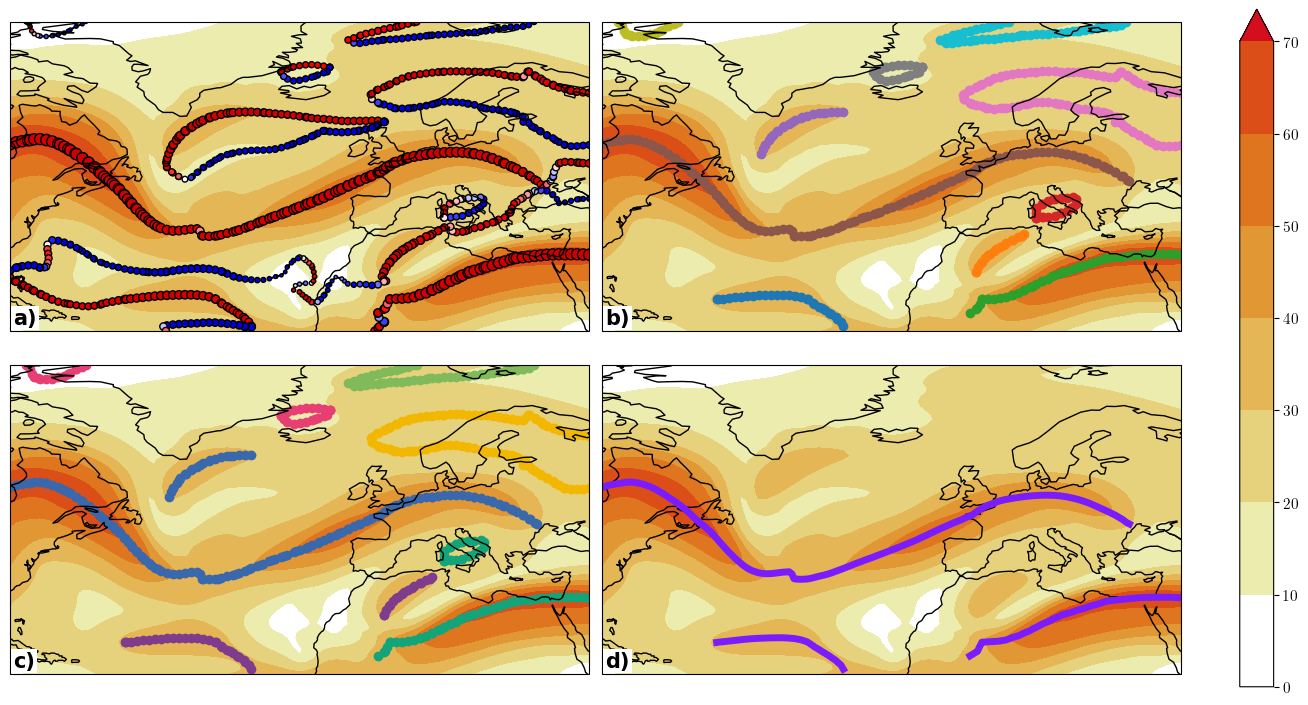

In [7]:
clu = Clusterplot(2, 2, get_region(ds_))
# it = np.random.randint(0, ds.time.shape[0])
# ds_ = preprocess(ds.isel(time=it), smooth_s=0.2)
lon, lat = ds_.lon.values, ds_.lat.values
cmap1 = colormaps.cet_l_wyor
clu.add_contourf([ds_["s"]] * 4, cmap=cmap1, transparify=1, levels=7)

ax = clu.axes[0]
dx = (ds_.lon[1] - ds_.lon[0]).item()
contours, types = contour_generator(x=lon, y=lat, z=ds_["sigma"].values * 1000, line_type="SeparateCode", quad_as_tri=False).lines(0.)
groups = []
for contour, types_ in zip(contours, types):
    if len(contour) < 15:
        continue
    group = interp_xy_ds(ds_, contour[::-1])
    group = compute_alignment(group)
    x, y, s, alignment = group.to_dataframe()[["lon", "lat", "s", "alignment"]].to_numpy().T
    ax.plot(x, y, lw=1.5, color="black", zorder=-10)
    ax.scatter(x, y, c=alignment, s=s, cmap=colormaps.BlWhRe, vmin=-1.5, vmax=1.5, edgecolors="black")
    
ax = clu.axes[1]
wind_threshold: float = 30
jet_threshold: float = 1.e8
alignment_threshold: float = 0.4
mean_alignment_threshold: float = 0.7
contours, types = contour_generator(x=lon, y=lat, z=ds_["sigma"].values * 1000, line_type="SeparateCode", quad_as_tri=False).lines(0.)
groups = []
colors_groups = colormaps.bold(np.linspace(0, 1, 20))
j = 0
for contour, types_ in zip(contours, types):
    if len(contour) < 15:
        continue
    cyclic: bool = 79 in types_ # code for line closing 
    group = interp_xy_ds(ds_, contour[::-1])
    group = compute_alignment(group)
    mask = (group["alignment"] > alignment_threshold) & (group["s"].values > wind_threshold)
    mask = mask.values
    indicess = get_runs_fill_holes(mask, hole_size=3, cyclic=cyclic)
    for indices in indicess:
        indices = np.unique(indices)
        if len(indices) < 10:
            continue
        group_df = group.to_dataframe().drop(columns="time").iloc[indices] # remove time
        group_ = group_df[["lon", "lat"]].values.astype(np.float32)
        clu.axes[1].scatter(*group_.T)
        labels = AgglomerativeClustering(n_clusters=None, distance_threshold=dx * 1.9, linkage="single").fit(group_).labels_
        masks = labels_to_mask(labels)
        for mask in masks.T:
            group_df_ = group_df.iloc[mask]
            groups.append(group_df_)
            clu.axes[2].scatter(*group_df_[["lon", "lat"]].to_numpy().T, color=colors_groups[j])
            j = j + 1
ax = clu.axes[3]
jets = []
for group_df in groups:
    bigjump = np.diff(group_df["lon"]) < -3 * dx
    if any(bigjump):
        here = np.where(bigjump)[0][0] + 1
        group_df = group_df.apply(np.roll, args=(-here,), raw=True)
    if "P" in group_df and any(group_df["P"] < 0):
        continue
    group_ = group_df[["lon", "lat", "s"]].values.astype(np.float32)
    jet_int = jet_integral_haversine(group_)
    mean_alignment = np.mean(group_df["alignment"].values)
    if jet_int > jet_threshold and mean_alignment > mean_alignment_threshold:
        jets.append(group_df)
for jet in jets:
    x, y, s, P, alignment = jet[["lon", "lat", "s", "lev", "alignment"]].to_numpy().T
    # im = ax.scatter(x, y, c=P, cmap=cmap, norm=norm)
    ax.plot(x, y, color=COLORS[1], lw=5)
        
for ax, letter in zip(clu.axes, list("abcd")):
    ax.annotate(f"{letter})", (2.2, 5.1), xycoords='axes points', ha="left", va="baseline", fontweight="demi", fontsize=15, bbox={"boxstyle": "square, pad=0.1", "edgecolor": "none", "facecolor": "white"}, usetex=False)
# clu.resize_relative([1.0, 0.875])

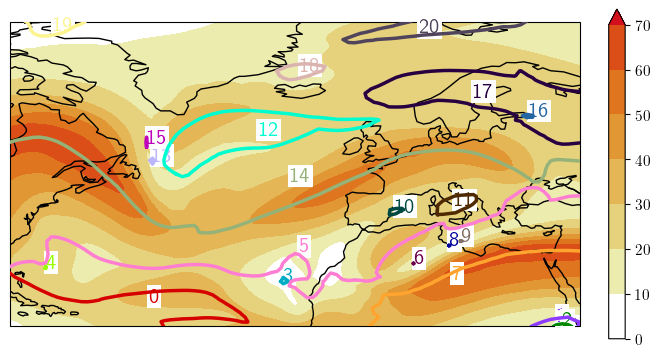

In [66]:
clu = Clusterplot(1, 1, get_region(ds))
clu.add_contourf([ds_["s"]], cmap=cmap1, transparify=1, levels=7)
ax = clu.axes[0]
contours, types = contour_generator(x=lon, y=lat, z=ds_["sigma"].values * 1000, line_type="SeparateCode", quad_as_tri=False).lines(0.)
groups = []
j = 0
colors_groups = colormaps.cet_g_bw(np.linspace(0, 1, 256))
for contour, types_ in zip(contours, types):
    if len(contour) < 5:
        continue
    cyclic: bool = 79 in types_ # code for line closing 
    group = interp_xy_ds(ds_, contour[::-1])
    group = compute_alignment(group)
    mask = (group["alignment"] > alignment_threshold) & (group["s"].values > wind_threshold)
    mask = mask.values
    indicess = get_runs_fill_holes(mask, hole_size=5, cyclic=cyclic)
    x, y, s, alignment = group.to_dataframe()[["lon", "lat", "s", "alignment"]].to_numpy().T
    ax.plot(x, y, lw=2.5, color=colors_groups[j], zorder=10)
    ax.text(np.mean(x), np.mean(y), str(j), fontweight="demi", color=colors_groups[j], fontsize=15, bbox={"boxstyle": "square, pad=0.1", "edgecolor": "none", "facecolor": "white"})
    if j == 14:
        for indices in indicess:
            indices = np.unique(indices)
            if len(indices) < 10:
                continue
            group_df = group.to_dataframe().drop(columns="time")
    j = j + 1

In [68]:
group_df

lev        member          s            time_bnds  \
points nbnd                                                             
0      0     199.905319  r10i1181p1f1  65.523998  1980-01-01 00:00:00   
       1     199.905319  r10i1181p1f1  65.523998  1980-01-02 00:00:00   
1      0     197.908081  r10i1181p1f1  65.317483  1980-01-01 00:00:00   
       1     197.908081  r10i1181p1f1  65.317483  1980-01-02 00:00:00   
2      0     197.908081  r10i1181p1f1  65.126944  1980-01-01 00:00:00   
...                 ...           ...        ...                  ...   
149    1     273.910828  r10i1181p1f1  26.339829  1980-01-02 00:00:00   
150    0     277.213587  r10i1181p1f1  27.165649  1980-01-01 00:00:00   
       1     277.213587  r10i1181p1f1  27.165649  1980-01-02 00:00:00   
151    0     280.089044  r10i1181p1f1  28.755432  1980-01-01 00:00:00   
       1     280.089044  r10i1181p1f1  28.755432  1980-01-02 00:00:00   

                     u          v         sigma        lon        lat  \
points nbnd                                                             
0      0     57.897233  30.677659 -2.768739e-20 -80.000000  54.242382   
       1     57.897233  30.677659 -2.768739e-20 -80.000000  54.242382   
1      0     60.294500  25.112600 -6.564505e-20 -78.750000  54.639832   
       1     60.294500  25.112600 -6.564505e-20 -78.750000  54.639832   
2      0     62.102414  19.613198  6.945670e-20 -77.500000  54.883283   
...                ...        ...           ...        ...        ...   
149    1     26.321979   0.450374 -1.641126e-21  38.000656  50.418848   
150    0     27.112527   1.637542 -3.536363e-20  38.750000  50.354448   
       1     27.112527   1.637542 -3.536363e-20  38.750000  50.354448   
151    0     28.595889   2.956078  1.228198e-20  40.000000  50.298379   
       1     28.595889   2.956078  1.228198e-20  40.000000  50.298379   

             alignment  
points nbnd             
0      0      0.983930  
       1      0.983930  
1      0      0.989659  
       1      0.989659  
2      0      0.991309  
...                ...  
149    1      0.993575  
150    0      0.992612  
       1      0.992612  
151    0      0.988846  
       1      0.988846  

[304 rows x 10 columns]

In [63]:
indicess[0]

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151])

In [58]:
group["s"]

<xarray.DataArray 's' (points: 152)> Size: 1kB
array([65.524  , 65.31748, 65.12694, 64.81415, 64.65394, 64.20313,
       64.1277 , 64.29529, 64.29954, 64.26134, 64.45956, 64.55772,
       64.69987, 64.97996, 65.08397, 65.38516, 65.41762, 65.55675,
       65.5566 , 65.30399, 65.28838, 64.8987 , 64.88051, 64.07407,
       63.8309 , 63.00521, 62.55608, 62.18207, 61.66763, 61.37198,
       61.14582, 60.96174, 60.27126, 60.15615, 59.09562, 58.30253,
       57.79568, 56.09318, 55.79979, 53.53001, 52.4985 , 51.08859,
       49.40338, 48.41939, 46.63545, 45.68106, 44.37343, 42.21479,
       40.19661, 38.21515, 36.45322, 35.13176, 34.23638, 34.01717,
       34.07658, 34.04268, 34.32083, 34.85801, 35.13166, 35.43976,
       35.94928, 36.53209, 36.89299, 37.23655, 38.1344 , 38.84634,
       39.29943, 40.61358, 41.36063, 42.03406, 43.50464, 44.29984,
       44.97476, 46.48079, 47.35437, 47.97917, 49.42278, 50.15908,
       50.71619, 51.91406, 52.40266, 52.83114, 53.66461, 53.84664,
       54.06091, 54.50094, 54.50752, 54.51268, 54.59734, 54.48561,
       54.39291, 54.36469, 53.69744, 53.31547, 53.15266, 52.34017,
       52.08044, 51.81344, 51.29674, 51.14521, 50.6439 , 50.36775,
       50.32192, 50.44257, 50.34395, 50.20205, 50.48934, 50.42609,
       50.30059, 50.31099, 50.31433, 50.29666, 50.24671, 49.80997,
       49.4228 , 49.08906, 48.87589, 48.78426, 48.75965, 48.78022,
       48.71699, 48.08736, 47.52139, 47.15324, 46.99661, 45.78928,
       44.9478 , 44.57324, 42.7639 , 42.05241, 40.61822, 38.37082,
       38.32837, 35.2127 , 34.41611, 31.6876 , 30.15724, 27.07217,
       24.32677, 24.11312, 24.17832, 24.3083 , 25.06089, 25.20351,
       24.87816, 24.8034 , 24.38035, 24.62348, 25.71761, 26.33983,
       27.16565, 28.75543])
Coordinates:
    member   <U12 48B 'r10i1181p1f1'
    time     datetime64[ns] 8B 1980-01-01T12:00:00
Dimensions without coordinates: points

In [29]:
indicess

[array([41, 42, 43, 44, 45, 46, 47, 48, 49, 50])]

In [24]:
indicess

[array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54])]

In [56]:
for contour, types_ in zip(contours, types):
    if len(contour) < 15:
        continue
    cyclic: bool = 79 in types_ # code for line closing 
    group = interp_xy_ds(ds_, contour[::-1])
    group = compute_alignment(group)
    mask = (group["alignment"] > alignment_threshold) & (group["s"].values > wind_threshold)
    mask = mask.values
    indicess = get_runs_fill_holes(mask, hole_size=5, cyclic=cyclic)
    for indices in indicess:
        indices = np.unique(indices)
        if len(indices) < 5:
            continue
        group_df = group.to_dataframe().drop(columns="time").iloc[indices] # remove time
        group_ = group_df[["lon", "lat"]].values.astype(np.float32)
        labels = AgglomerativeClustering(n_clusters=None, distance_threshold=dx * 1.9, linkage="single").fit(group_).labels_
        masks = labels_to_mask(labels)
        for mask in masks.T:
            groups.append(group_df.iloc[mask])

In [58]:
group

<xarray.Dataset> Size: 4kB
Dimensions:    (points: 78, nbnd: 2)
Coordinates:
    member     <U12 48B 'r10i1251p1f1'
    time       datetime64[ns] 8B 1980-01-01T12:00:00
    time_bnds  (nbnd) object 16B dask.array<chunksize=(2,), meta=np.ndarray>
Dimensions without coordinates: points, nbnd
Data variables:
    lev        (points) float32 312B dask.array<chunksize=(78,), meta=np.ndarray>
    s          (points) float32 312B dask.array<chunksize=(78,), meta=np.ndarray>
    u          (points) float32 312B dask.array<chunksize=(78,), meta=np.ndarray>
    v          (points) float32 312B dask.array<chunksize=(78,), meta=np.ndarray>
    sigma      (points) float64 624B dask.array<chunksize=(78,), meta=np.ndarray>
    lon        (points) float64 624B 40.0 38.75 37.5 36.25 ... 26.56 26.25 26.03
    lat        (points) float64 624B 72.96 72.85 72.74 ... 78.69 79.46 79.63
    alignment  (points) float64 624B dask.array<chunksize=(78,), meta=np.ndarray>
Attributes: (12/17)
    Conventions:                       CF-1.0
    intake_esm_attrs:_data_format_:    zarr
    intake_esm_attrs:component:        atm
    intake_esm_attrs:end_time:         2014-12-31 12:00:00
    intake_esm_attrs:experiment:       historical
    intake_esm_attrs:forcing_variant:  cmip6
    ...                                ...
    intake_esm_dataset_key:            atm.historical.daily.cmip6
    logname:                           sunseon
    model_doi_url:                     https://doi.org/10.5065/D67H1H0V
    source:                            CAM
    time_period_freq:                  day_1
    topography_file:                   /mnt/lustre/share/CESM/cesm_input/atm/...

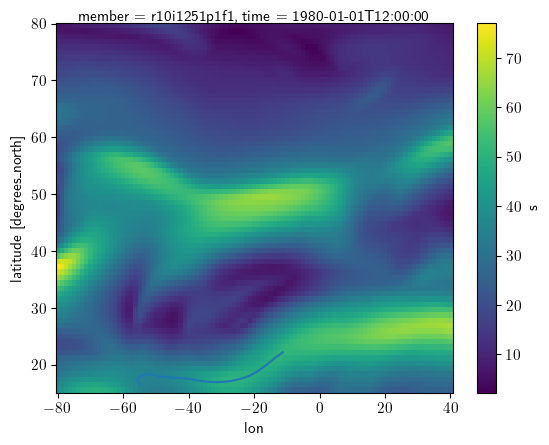

In [51]:
ds_["s"].plot()
plt.plot(*jets[0][["lon", "lat"]].to_numpy().T)

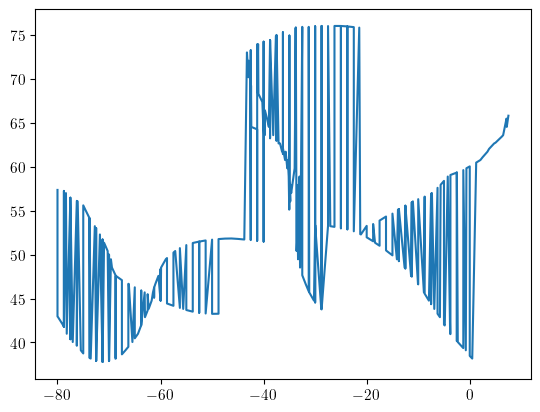

In [24]:
jet = jet.sort_values("lon")
lo, la, s = jet[["lon", "lat", "s"]].to_numpy().T
plt.plot(lo, la)

# CESM

In [1]:
from pathlib import Path
import numpy as np
import xarray as xr
basepath = Path("/storage/workspaces/giub_meteo_impacts/ci01/CESM2/flat_wind")
paths = list(basepath.iterdir())
paths = [path for path in paths if path.suffix == ".nc" and path.name != "ds.nc"]
parts = [path.name.split(".")[0].split("-") for path in paths]
parts = np.asarray(parts)
sorted_order = np.argsort([memb.replace("r10", "r0") for memb in parts[:, 0]])
parts = parts[sorted_order]
paths = [paths[i] for i in sorted_order]
all_members = np.unique(parts[:, 0])
all_years = np.unique(parts[:, 1])

not_here = []
here = []
for year in all_years:
    for member in all_members:
        potential_path = basepath.joinpath(f"{member}-{year}.nc")
        if potential_path.is_file():
            here.append(potential_path)
        else:
            not_here.append(potential_path)
len(here)

from itertools import groupby
paths_to_load = []
valid_ensembles = []
for key, indices in groupby(range(len(parts)), lambda i: parts[i][0]):
    indices = list(indices)
    group = parts[indices]
    these_paths = [paths[i] for i in indices]
    years = np.asarray(list([g[1] for g in group]))
    if len(years) == 60:
        paths_to_load.append(these_paths)
        valid_ensembles.append(key)
    else:
        print(key, len(years))

r2i1021p1f1 30


In [11]:
from tqdm import tqdm
ds = []
for ptl in tqdm(paths_to_load):
    ds_ = []
    for p in ptl:
        this = xr.open_dataset(p)
        this = this.reset_coords("time_bnds", drop=True).drop_dims("nbnd")
        ds_.append(this)
    ds.append(xr.concat(ds_, dim="time"))
ds = xr.concat(ds, dim="member")
# ds = xr.concat([xr.concat([xr.open_dataset[ptl_] for ptl_ in ptl], dim="time") for ptl in paths_to_load], dim="member")

  0%|          | 0/49 [00:00<?, ?it/s]

100%|██████████| 49/49 [07:52<00:00,  9.64s/it]


In [ ]:
import dask
from dask.distributed import progress, Client
from jetstream_hugo.definitions import COMPUTE_KWARGS
client = Client(**COMPUTE_KWARGS)
dask.persist(ds)
progress(ds, notebook=False)
ds = dask.compute(ds)

In [16]:
ds = ds[0]
to_comp = ds.to_zarr(f"/storage/workspaces/giub_meteo_impacts/ci01/CESM2/flat_wind/ds.zarr", compute=False, encoding={var: {"chunks": (-1, 100, -1, -1)} for var in ds.data_vars}, mode="w")
dask.persist(to_comp)
progress(to_comp, notebook=False)
dask.compute(to_comp)

(None,)

# Daskify

In [25]:
data_handlers = {}
for varname in ["u", "v", "s"]:
    dh = DataHandler.from_specs("ERA5", "plev", varname, "6H", "all", None, -80., 40., 15., 80., [175, 200, 225, 250, 300, 350], reduce_da=False)
    data_handlers[varname] = dh
data_handler = DataHandler.from_several_dhs(data_handlers)
exp = JetFindingExperiment(data_handler)
ds = exp.ds


# extreme cesm clim

In [16]:
import numpy as np
from jetstream_hugo.data import *
quantiles = ds["s"].quantile(np.arange(0.6, 1, 0.05), ["member", "lon", "lat"]).compute()
quantiles = smooth(quantiles, {"time": ("win", 15)}).load()
quantiles.to_netcdf(f"{DATADIR}/CESM2/flat_wind/results/s_q.nc")


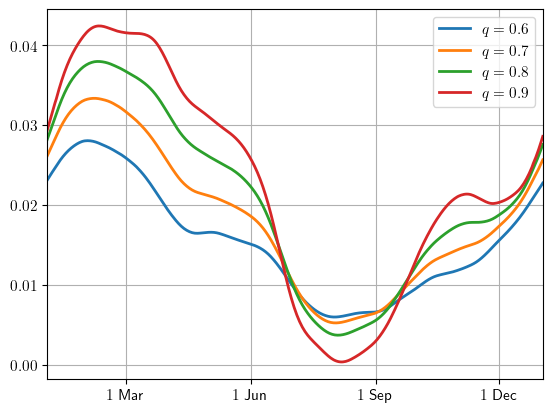

In [19]:
from matplotlib.dates import DateFormatter, MonthLocator
from jetstream_hugo.definitions import *
from scipy.stats import linregress

def get_trend(da):
    years = np.unique(da.time.dt.year)
    if "jet" not in da.dims:
        result = linregress(years, da.values)
        return xr.Dataset({"slope": result.slope, "p": result.pvalue})
    jets = da.jet.values
    slopes = xr.DataArray(np.zeros(len(jets)), coords={"jet": jets})
    pvalues = slopes.copy()
    for j, jet in enumerate(jets):
        result = linregress(years, da.isel(jet=j).values)
        slopes[j] = result.slope
        pvalues[j] = result.pvalue
    return xr.Dataset({"slope": slopes, "p": pvalues})

winsize = 15
halfwinsize = int(np.ceil(winsize / 2))

fig, ax = plt.subplots()
for q, qval in zip(quantiles[::2], np.arange(0.6, 1, 0.05 * 2)):
    gb = q.groupby("time.dayofyear")
    x = list(gb.groups)
    x = DATERANGE[x]
    ys = gb.map(get_trend) 
    ps = ys["p"]
    ys = ys["slope"]
    ys = ys.pad({"dayofyear": halfwinsize}, mode="wrap")
    ys = ys.rolling(dayofyear=winsize, center=True).mean()
    ys = ys.isel({"dayofyear": slice(halfwinsize, -halfwinsize)})
    ax.plot(x, ys, label=f"$q={qval:.1f}$", lw=2)
ax.grid(True)
ax.xaxis.set_major_locator(MonthLocator(range(0, 13, 3)))
ax.xaxis.set_major_formatter(DateFormatter("1 %b"))
ax.set_xlim(min(x), max(x))
ax.legend()

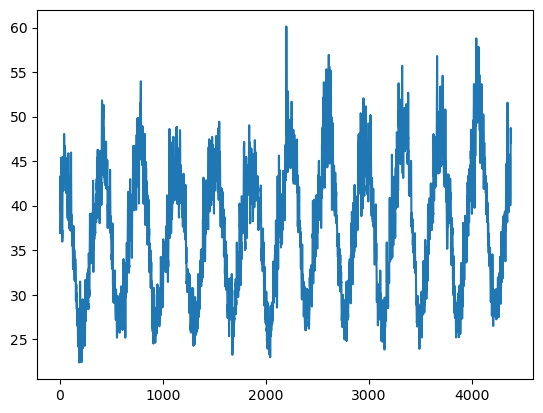

In [10]:
q_clim = compute_clim(quantiles, "dayofyear")
q_clim = smooth(q_clim, {"dayofyear": ("win", 61)}).load()
q_clim.to_netcdf(f"{DATADIR}/CESM2/flat_wind/results/s_q_clim.nc")

In [19]:
ds = ds.reset_coords("time_bnds", drop=True)

# Extreme experiment

In [ ]:
exp_tp = ExtremeExperiment(
    DataHandler("ERA5", "surf", "tp", "6H", "all", "JJA", -30, 40, 30, 75, 250, 'hourofyear', {'hourofyear': ('win', 4 * 15)}, None),
    q = 0.95,
)
da_tp = exp_tp.da.load()

data_handlers = {}
for varname in ["u", "v", "s"]:
    dh = DataHandler("ERA5", "plev", varname, "6H", "all", None, -80, 40, 15, 80, [175, 200, 225, 250, 300, 350], reduce_da=False)
    data_handlers[varname] = dh
exp = MultiVarExperiment(data_handlers)

all_jets_one_df, where_are_jets, all_jets_one_array, all_jets_over_time, flags = exp.track_jets()
props_as_ds = exp.props_as_ds(True)

In [ ]:
from deepdiff import DeepHash
DeepHash(load_pickle("/storage/workspaces/giub_meteo_impacts/ci01/ERA5/surf/tp/6H/hourofyear_hourofyearwin60/results/1/predictions/1/metadata.pkl"))

{'n_clu': 'f7d339d7242593cf7bacb03b4648e837ae9cd8ce0f70b43f2205848296cf18d6', 11: 'fa26322d0f2ff88344439244a7df169ea50f03fa52ec69ff090791329db4e06f', 'q': 'ee5da069bca4e15d4536ace9d495f182cff455ff5156ad6cb383d41043ad6fe3', 0.95: 'f7d6e1d019c39117d19622ec38491cf2c8a97a485b09091b33645d4099dff124', 'simple': 'f7fdc0e90632355be9e3fd9b0a9ebb265a227b3909a48a09282fb451697b7035', <BoolObj.FALSE: 0>: 'b195620d3676be89da6277412918e9f4e5e2bf23b0eaacfcf674c87609c67f3a', 'minlen': '57c29967c27c63a5330cbe4...}

In [ ]:
subset = ["mean_lon", "mean_lat", "mean_lev", "spe_star", "width", "wavinessR16", "persistence", "com_speed", "int"]
predictors = prepare_predictors(
    props_as_ds,
    subset=subset,
    anomalize=True,
    normalize=True,
    detrend=True,
    nan_method="nearest",
    season="JJA",
)
time_before = pd.Timedelta(0, "D")
n_clu = 22
clusters_da = exp_tp.spatial_clusters_as_da(n_clu)
targets, length_targets, all_spells_ts, all_spells = exp_tp.create_targets(n_clu, 0.95, minlen=np.timedelta64(1, "D"))
binary_targets = length_targets > 0
masked_predictors = mask_from_spells_multi_region(predictors, targets, all_spells_ts, all_spells, time_before=time_before)

100%|██████████| 22/22 [00:05<00:00,  4.01it/s]


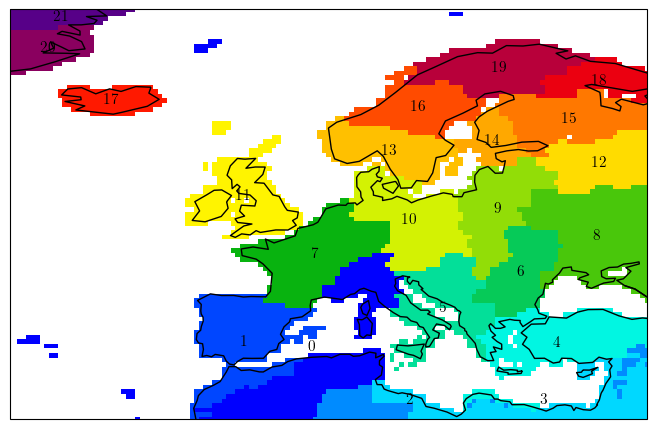

In [ ]:
clu = Clusterplot(1, 1, exp_tp.region)
cmap = colormaps.BlAqGrYeOrReVi200
ax = clu.axes[0]
unique_clusters = np.arange(n_clu)
norm = BoundaryNorm(np.concatenate([[-1], unique_clusters]) + 0.5, cmap.N)
clusters_da.unstack().plot(
    ax=ax,
    cmap=cmap,
    norm=norm,
    add_colorbar=False,
    add_labels=False
)
for j in range(n_clu):
    lo = clusters_da.lon.where(clusters_da==j).mean().item()
    la = clusters_da.lat.where(clusters_da==j).mean().item()
    ax.text(lo, la, f"${j}$", ha="center", va="center", fontweight="bold")

In [ ]:
compute_all_smoothed_anomalies("ERA5", "plev", "s", "6H", 'hourofyear', {'hourofyear': ('win', 4 * 15)}, None)

[########################################] | 100% Completed | 43m 20s


100%|██████████| 768/768 [1:00:00<00:00,  4.69s/it]


In [ ]:
compute_all_smoothed_anomalies("ERA5", "surf", "tp", "6H", 'hourofyear', {'hourofyear': ('win', 4 * 15)}, None)

/storage/homefs/hb22g102/miniforge3/envs/env11_2/lib/python3.11/site-packages/xarray/core/indexing.py:1620: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]
100%|██████████| 83/83 [02:30<00:00,  1.81s/it]


In [ ]:
basepath = Path(f"{DATADIR}/ERA5/surf")
varnames = ["u10", "v10", "s10"]
for year, month in tqdm(product(YEARS, range(1, 13)), total=len(YEARS) * 12):
    month_str = str(month).zfill(2)
    ofiles = {varname: basepath.joinpath(f"{varname}/6H/{year}{month_str}.nc") for varname in varnames}
    if all([ofile.is_file() for ofile in ofiles.values()]):
        continue
    ds = xr.open_dataset(basepath.joinpath(f"raw/{year}{month_str}.nc"))
    ds = ds.rename(longitude="lon", latitude="lat")
    ds = ds.assign_coords(lon=(((ds.lon + 180) % 360) - 180))
    ds = ds.sortby("lon")
    ds = ds.sortby("lat")
    ds["s10"] = np.sqrt(ds["u10"] ** 2 + ds["v10"] ** 2)
    for varname in varnames:
        da = ds[varname]
        with warnings.catch_warnings():
            warnings.simplefilter("ignore", category=xr.SerializationWarning)
            da.to_netcdf(ofiles[varname])

  0%|          | 0/768 [00:00<?, ?it/s]

100%|██████████| 768/768 [25:46<00:00,  2.01s/it]
